In [8]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import tensorflow as tf
from keras_tuner import RandomSearch
from models.model_manager import ModelManager
from data.data_manager import DataManager

from constants.klass_mappings import klass_mappings
from constants.transliterations import transliterations
from models.model_2 import Model2
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
X_train = pd.read_csv('./data/train_x.csv')
X_test = pd.read_csv('./data/test_x.csv')
y_train = pd.read_csv('./data/train_y.csv')
y_test = pd.read_csv('./data/test_y.csv')

# build validation dataset from training dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


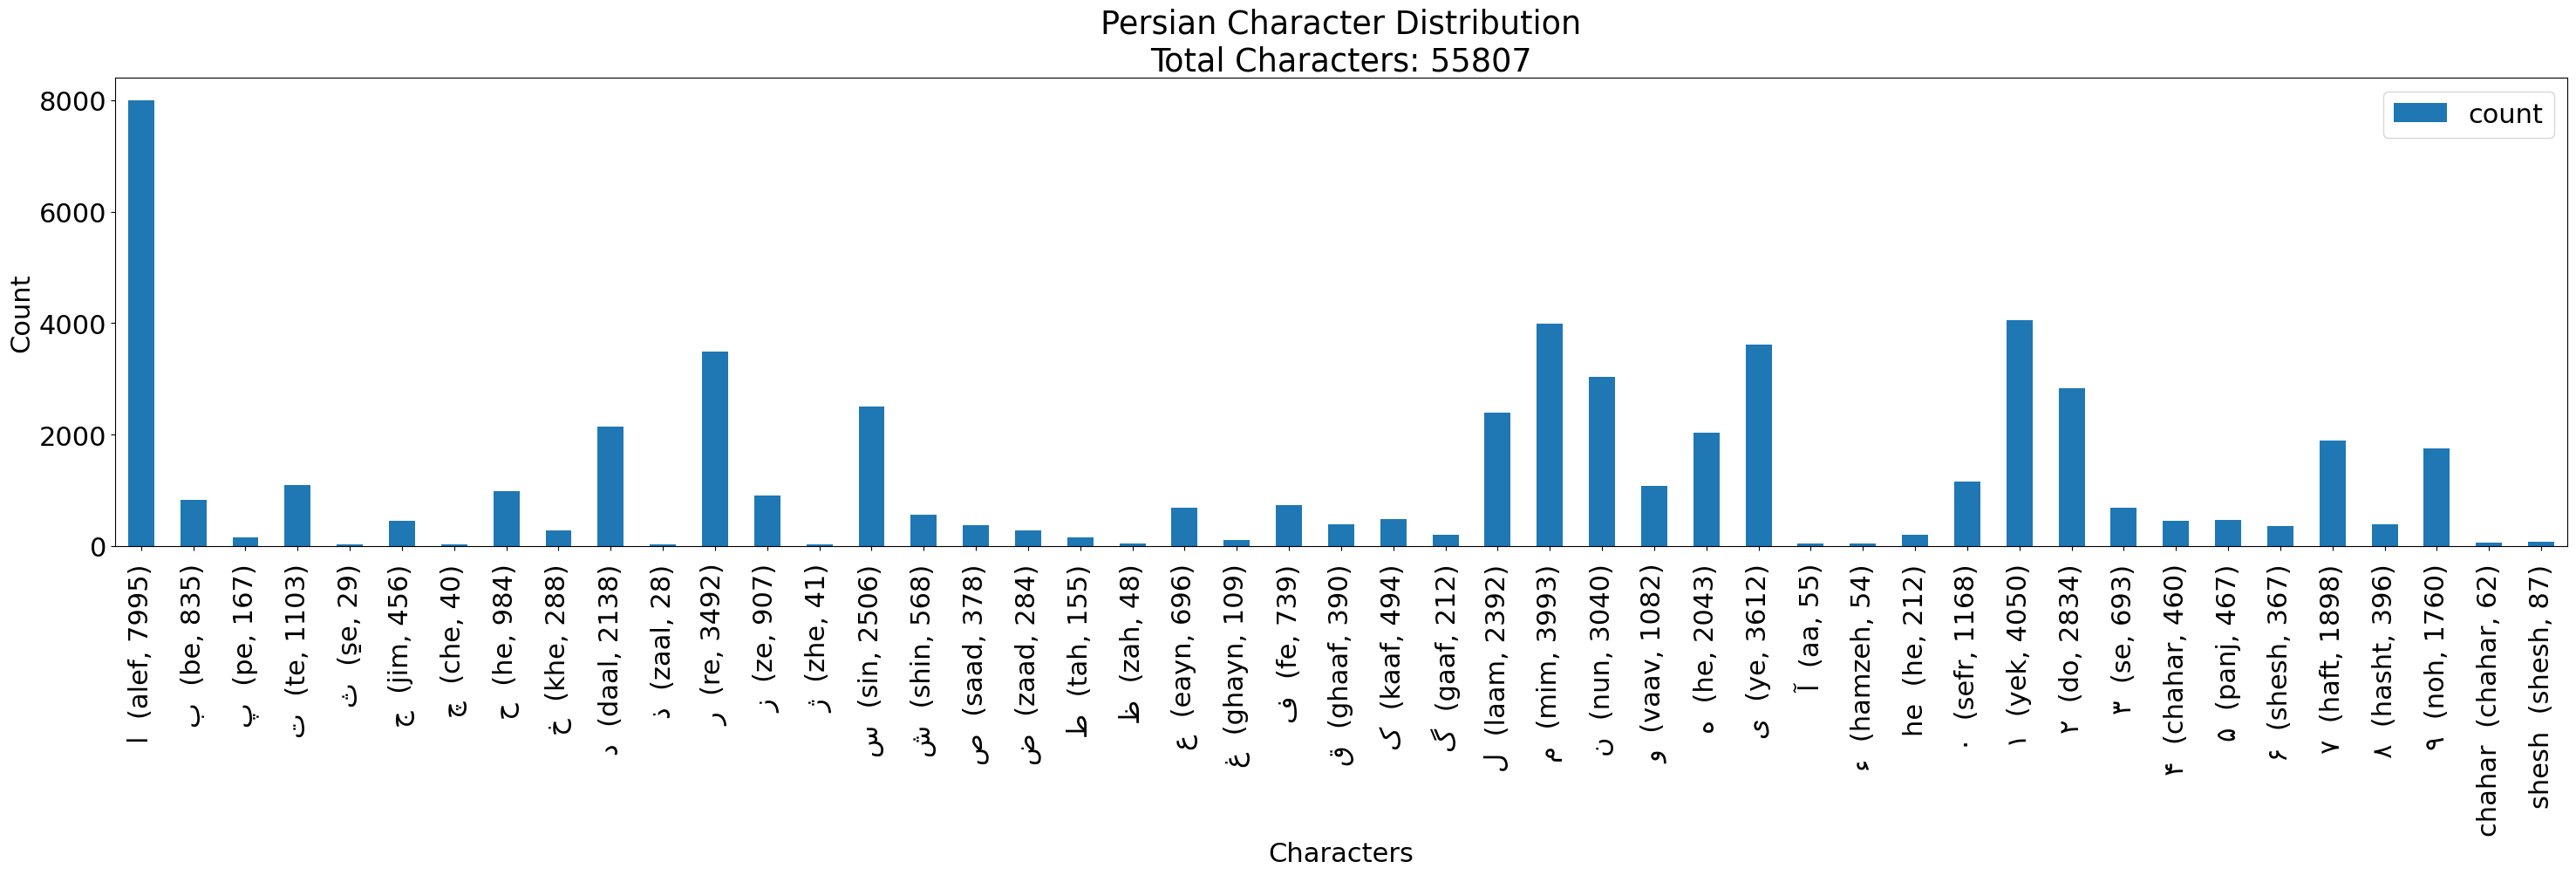

In [23]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
mappings_df = y_train.groupby('1')['1'].count().to_frame()
mappings_df = mappings_df.rename(columns={'1': 'count'})
mappings_df['klass'] = mappings_df.index
mappings_df['character'] = mappings_df['klass'].apply(lambda x: klass_mappings[x])
mappings_df['transliteration'] = mappings_df['klass'].apply(lambda x: transliterations[x])
mappings_df['klass_transliteration'] = mappings_df['klass'].apply(lambda x: f'{klass_mappings[x]}  ({transliterations[x]}, {mappings_df["count"][x]}) ')
mappings_df['proportion'] = mappings_df['klass'].apply(lambda x: mappings_df['count'][x] / mappings_df['count'][1])
fig = mappings_df[['klass_transliteration', 'count']].plot(kind='bar', xlabel=f'Characters', ylabel='Count', title=f"Persian Character Distribution\nTotal Characters: {X_train.shape[0]}", x='klass_transliteration', figsize=(30,10)).get_figure()
fig.tight_layout()
fig.subplots_adjust(bottom=0.35)
fig.savefig('./images/character_distribution.png')

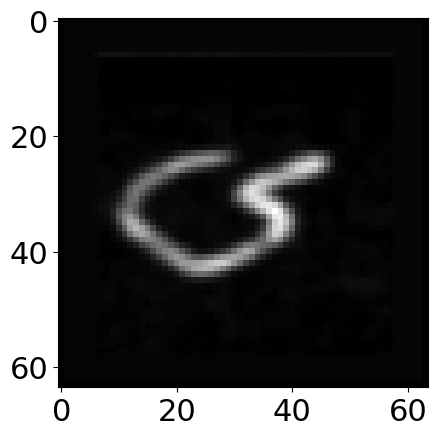

In [24]:
plt.imshow(X_train.iloc[18027].values.reshape((64, 64)), cmap = "gray_r")

In [3]:
# take a small random sample for tuning purposes
X_train_sample = X_train.sample(n=15000, random_state=6)
y_train_sample = y_train.loc[X_train_sample.index]
y_train_sample.groupby("1")["1"].count()

1
1     2204
2      213
3       34
4      285
5       11
6      107
7        9
8      281
9       93
10     561
11       5
12     942
13     226
14      14
15     702
16     162
17     104
18      81
19      38
20      14
21     185
22      34
23     216
24      91
25     129
26      52
27     614
28    1072
29     839
30     285
31     526
32     979
33      16
34      17
35      56
36     320
37    1061
38     808
39     163
40     115
41     124
42     110
43     496
44     100
45     472
46      13
47      21
Name: 1, dtype: int64

In [5]:
num_classes = 48
input_shape = (4096, 1)
desired_shape = (64, 64, 1)

In [27]:
tuner = RandomSearch(
    Model2(num_classes=num_classes, input_shape=input_shape, desired_shape=desired_shape),
        objective="val_accuracy",
        max_trials=100,
        max_consecutive_failed_trials=10,
        executions_per_trial=1,
        directory='tuning',
        project_name="hyperparams",
        overwrite=True
    )
tuner.search(X_train_sample, y_train_sample, epochs=1, validation_data=(X_train_sample, y_train_sample))

Trial 100 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.155266672372818
Total elapsed time: 00h 06m 48s


In [28]:
model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (None, 4096, 1)        │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 61, 61, 30)     │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │       576,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 576,558 (2.20 MB)

 Trainable params: 576,558 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

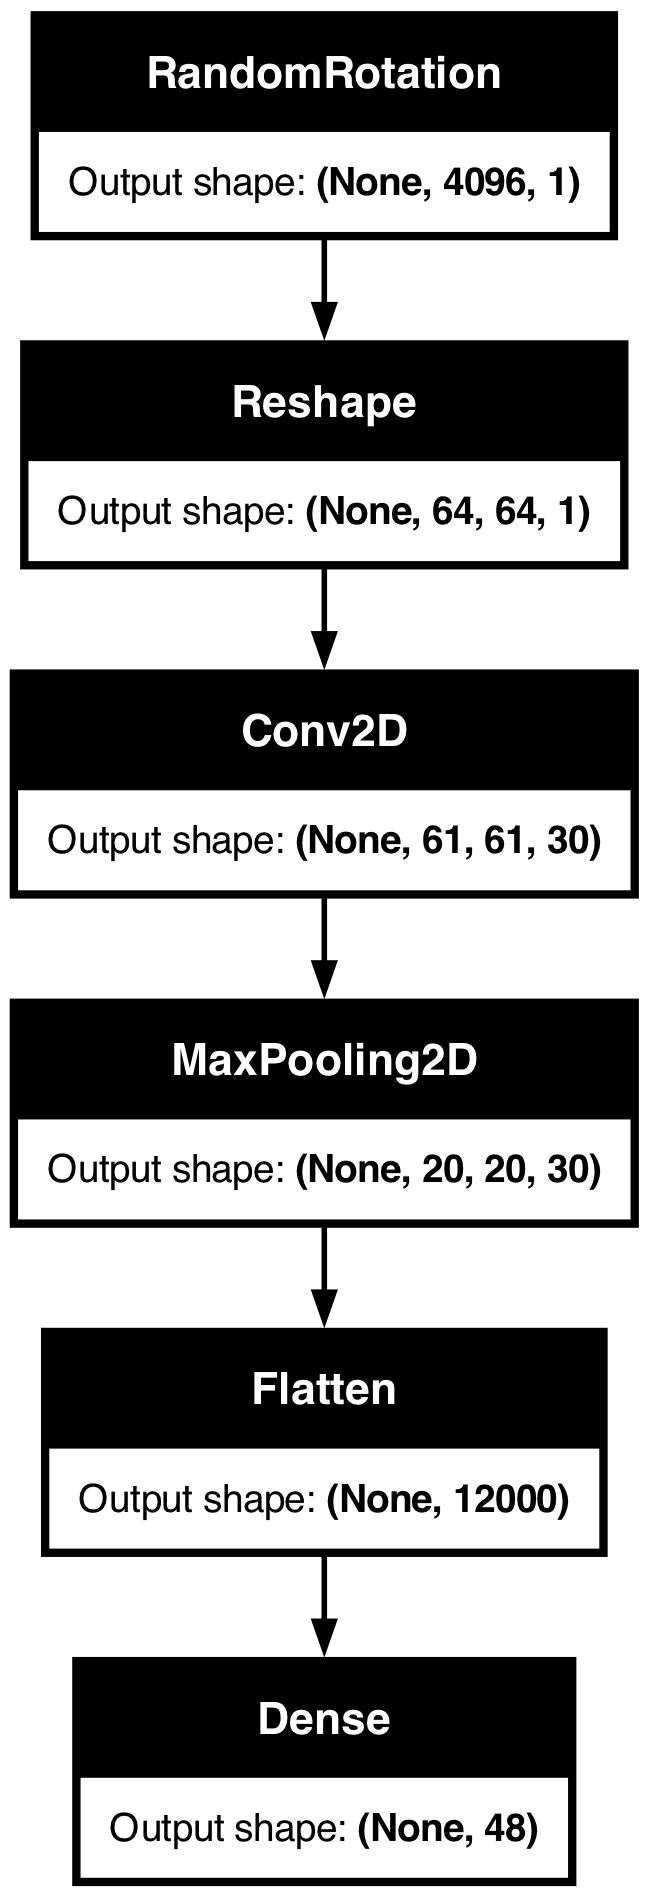

In [29]:
tf.keras.utils.plot_model(model, to_file='./images/model_2.png', show_shapes=True)

In [30]:
best_hyperparams = tuner.get_best_hyperparameters(10)[0]
best_hyperparams.values

{'conv_2_filter': 30,
 'conv_2_kernel': 4,
 'activation': 'relu',
 'l1': 0.01,
 'l2': 0.01,
 'pool_size': 2,
 'strides': 3,
 'optimizer': 'adam',
 'loss': 'sparse_categorical_crossentropy',
 'batch_size': 20}

In [7]:
hypermodel = Model2(num_classes=num_classes, input_shape=input_shape, desired_shape=desired_shape)
data_manager = DataManager()
model_manager = ModelManager(hypermodel, X_train_sample, y_train_sample=y_train_sample)
model_manager.search_tune_fit()

Trial 100 Complete [00h 00m 15s]
val_accuracy: 0.14720000326633453

Best val_accuracy So Far: 0.16300000250339508
Total elapsed time: 00h 08m 57s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (None, 4096, 1)        │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 61, 61, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 17, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │        38,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,408 (216.44 KB)

 Trainable params: 55,408 (216.44 KB)

 Non-trainable params: 0 (0.00 B)

{'conv_2_filter': 32, 'conv_2_kernel': 4, 'activation': 'relu', 'l1': 0.1, 'l2': 0.01, 'pool_size': 3, 'strides': 3, 'dropout': 0.25, 'optimizer': 'rmsprop', 'loss': 'sparse_categorical_crossentropy', 'batch_size': 100}


In [9]:
model_manager = ModelManager(hypermodel, X_train_sample, y_train_sample=y_train_sample)


AttributeError: 'ModelManager' object has no attribute 'model_name'